# Exogenous Regressors

> In this example we'll show how to include exogenous regressors.

An **exogenous regressor** is a variable that is independent of other variables in the system and that can have predictive value. In time series forecasting it is common to add these types of variables in hopes of improving our models.

In this notebook, you'll see how [StatsForecast](https://nixtla.github.io/statsforecast/) allows you to easily incorporate exogenous regressors to models that allow them, such as [AutoARIMA](https://nixtla.github.io/statsforecast/models.html#autoarima). 

**Outline**

1. Install libraries
2. Load and explore the data
3. Add exogenous regressors
4. Create future exogenous regressors
5. Train the model and predict 
6. Include prediction intervals

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/Exogenous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html) 

Install the necessary packages using `pip install statsforecast`

In [ ]:
pip install statsforecast 

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from statsforecast.utils import AirPassengersDF as Y_df
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

## Load and explore the data

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 

In this example, we will use the `AirPassengers` dataset to forecast the last 12 observations. 

In [ ]:
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


In [ ]:
# Separate data in train and test sets
horizon = 12
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

## Add exogenous regressors

For this particular case, we'll only include the `trend` as an exogenous regressor. You can incorporate other exogenous regressors repeting the procedure shown below. Keep in mind that `StatsForecast` considers as exogenous variables all columns after the column `y`. 

In [ ]:
Y_train_df['trend'] = np.arange(1, len(Y_train_df) + 1)
Y_train_df.head()

,unique_id,ds,y,trend
0,1.0,1949-01-31,112.0,1
1,1.0,1949-02-28,118.0,2
2,1.0,1949-03-31,132.0,3
3,1.0,1949-04-30,129.0,4
4,1.0,1949-05-31,121.0,5


::: {.callout-note}
## Note
Observe that the exogenous regressors have to be placed _after_ the target variable `y`.
:::

### Create future exogenous regressors

We need to include the future values of the exogenous regressors so that the model can produce forecasts. Hence, in this section, we'll construct a dataframe that includes the future `trend`. When deciding which exogenous regressors to use, make sure that you select the ones whose future values you known in advance; otherwise, you need to obtain them elsewhere or forecast them. 

In [ ]:
X_test_df = pd.DataFrame({
  'unique_id': 1.0,
  'ds': pd.date_range(start='1960-01-01', periods=horizon, freq='M')
})

# We construct xreg for test. The train series ends at the 133th step. 
X_test_df['trend'] = np.arange(133, 133 + horizon)
X_test_df.head()

,unique_id,ds,trend
0,1.0,1960-01-31,133
1,1.0,1960-02-29,134
2,1.0,1960-03-31,135
3,1.0,1960-04-30,136
4,1.0,1960-05-31,137


## Train the model and predict 

To generate the forecast, we first need to instantiate a  new `StatsForecast` object with the following required parameters:

* `models`: a list of [models](../models.ipynb). 

* `freq`: a string indicating the frequency of the data. See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [ ]:
# Create a list of models and instantiation parameters
model = StatsForecast(
    df=Y_train_df, 
    models=[AutoARIMA(season_length=12)], 
    freq='M', 
    n_jobs=-1
)

Once the model has been instantiated, we can predict the next 12 observations with the `StatsForecast.forecast` method. This method is computationally more efficient than `StatsForecast.predict` since it doesn't save objects during training and predicting. 

Here is also where we need to incluide the future values of the exogenous regressors, which are contained in `X_test_df`. 

In [ ]:
Y_hat_df = model.forecast(horizon, X_df=X_test_df)

For efficiency's sake, the forecast method converts the `unique_id` column to an index. You can revert to the default index of the data frame using the [pd.reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) method from Pandas.

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,AutoARIMA
0,1.0,1960-01-31,414.551483
1,1.0,1960-02-29,387.550842
2,1.0,1960-03-31,445.526978
3,1.0,1960-04-30,431.495422
4,1.0,1960-05-31,452.797211


We can now plot the forecasts

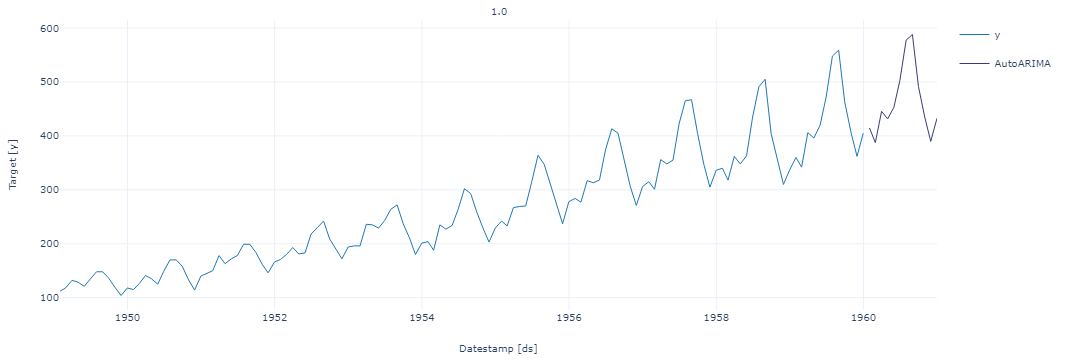

In [ ]:
StatsForecast.plot(Y_train_df, Y_hat_df)

## Include prediction intervals

You can also compute prediction intervals using exogenous regressors. To do this, simply add the `level` argument to `StatsForecast.forecast`. For example, `levels=[80, 95]` returns the 80% and 95% [prediction intervals](https://nixtla.github.io/statsforecast/examples/uncertaintyintervals.html).  

In [ ]:
Y_hat_df = model.forecast(horizon, X_df=X_test_df, level=(80,95))
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
0,1.0,1960-01-31,414.551483,393.468414,400.765991,428.337006,435.634583
1,1.0,1960-02-29,387.550842,362.181641,370.962830,404.138855,412.920044
2,1.0,1960-03-31,445.526978,418.457153,427.826965,463.226990,472.596832
3,1.0,1960-04-30,431.495422,403.697540,413.319366,449.671478,459.293304
4,1.0,1960-05-31,452.797211,424.679352,434.411926,471.182495,480.915070


Just as before, we can plot the forecast

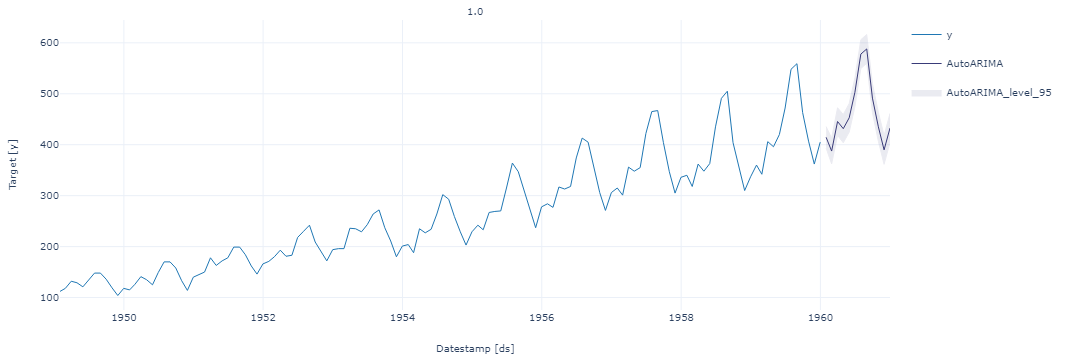

In [ ]:
StatsForecast.plot(Y_train_df, Y_hat_df)